# ASI assessed exercise 2019/2020

#### BARTHELEMY Jeanne

### Imports

In [72]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy as scipy
import scipy.spatial
from scipy.stats import multivariate_normal
import matplotlib 
import matplotlib.font_manager
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from tqdm import tqdm
import time 
import warnings
import torch
import torch.nn as nn
from functools import total_ordering
warnings.filterwarnings("ignore")
def set_seed(seed: int=0):
    np.random.seed(seed)
#Torch helper functions
def args_as_tensors(*index):
    """A simple decorator to convert numpy arrays to torch tensors"""
    def decorator(method):
        def wrapper(*args, **kwargs):
            converted_args = [torch.tensor(a).float() 
                              if i in index and type(a) is np.ndarray else a 
                              for i, a in enumerate(args)]
            return method(*converted_args, **kwargs)
        return wrapper  
    return decorator

print("import complete")

import complete


#### a)  Download and import the Santander dataset. The labels of the test data are not publicly available, so create your own test set by randomly choosing half of the instances in the original training set.

In [2]:
data = pd.read_csv("train.csv")
#data = pd.read_csv("train.csv").head(20000)#Smaller dataset (1/10) first (to change later on)
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [3]:
y = data['target']
X = data.drop(['target', 'ID_code'], axis=1)
X.head(3)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965


Let's do a short Preprocessing that will allow us to boost the learning process and avoid NAN in training sessions below : the values of the columns will be between 0 and 1

In [4]:
x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)
X.head(3) #to have a look at the effect of our preprocessing

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.427853,0.324824,0.568059,0.388041,0.550670,0.467321,0.454298,0.594255,0.270395,0.247420,...,0.569515,0.342943,0.568958,0.448173,0.510975,0.300318,0.678981,0.430958,0.327658,0.560645
1,0.557212,0.428639,0.681235,0.410417,0.628408,0.795072,0.536604,0.500584,0.660911,0.573056,...,0.668079,0.536531,0.523717,0.756190,0.350211,0.765154,0.686614,0.468277,0.609546,0.605827
2,0.411969,0.483777,0.578061,0.599690,0.474941,0.471329,0.753295,0.414724,0.270429,0.276041,...,0.522496,0.643141,0.448960,0.448000,0.671183,0.881350,0.236337,0.381950,0.425833,0.582736


In [5]:
#Random Train/test split, and convert to numpy array
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()
X_train_size = X_train.shape
print("Shape of the training set: "+str(X_train_size))

Shape of the training set: (100000, 200)


#### b) (text) Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis. [7]

By having a look at the target column (ground truth), we can see that there are far many much more targets equal to 0 than 1... This will not ease the learning process, as the model might end up predicting something close to 0 for every input, in order to minimize the loss function...
Furthermore, we can see (once the "id" and "target" columns are removed) that there are 200 input features for each input. This will be consuming space, and the matrix inversions might end up being time consuming. The choleski trick for covariance inverse will be useful.

## 1. Bayesian Linear Regression

#### a) Implement Bayesian linear regression

In what follows, I adapted the code of the first bayesian linear regression of the labs, with a gaussian loglikelihood. This bayesian linear regression is quite simplified, with the covariance matrix of the prior being assumed to be diagonal.
We could however improve the model by being bayesian on the noise : I did not implement it for this specific Santander dataset, but you can have a look at what the implementation could look like (from the lab, for the lab data), in the Annex. 

In [6]:
def lognormal(x, mu, va):
    return np.log(1/(np.sqrt(va*2*np.pi)))-0.5*((x-mu)**2/va)  

def gaussian_loglik(y, y_tilde, sigma2noise):
    return lognormal(y,y_tilde, sigma2noise) #

def build_X(X, K):
    assert K > 0 and isinstance(K, int)    
    return np.column_stack(X**i for i in range(K+1))

In [7]:
def compute_posterior(X, y, sigma2priorweights, sigma2noise, print_ = False):
    Sigma_inverse =  (1/sigma2priorweights)*np.eye(len(X[0])) + (1/sigma2noise)*np.matmul(X.T,X)  
    choleski = np.linalg.cholesky(Sigma_inverse) #lower matrix (choleski decomposition) (triangular matrix)
    choleski_inverse = np.linalg.inv(choleski) #inverse of this lower matrix: no np.linalg.inv on the full covariance 
    posterior_Sigma = np.dot(choleski_inverse.T,choleski_inverse) #We get sigma (property on exchanging inverse/transpose for triangular matrix)
    posterior_mu =    (1/sigma2noise)*np.matmul(posterior_Sigma.T,np.matmul(X.T,y)) 
    return posterior_mu.reshape((len(posterior_mu),1)), posterior_Sigma

In [8]:
def compute_predictive(Xnew, w_posterior_mu, w_posterior_Sigma, sigma2noise, K):   
    Xnew = build_X(Xnew, K)
    y_posterior_mu =  np.dot(Xnew,w_posterior_mu) 
    y_posterior_mu  =  y_posterior_mu.reshape(y_posterior_mu.shape[0]) 
    y_posterior_sigma2 = np.diag(np.dot(np.dot(Xnew,w_posterior_Sigma),Xnew.T)) + sigma2noise
    y_posterior_sigma2 = y_posterior_sigma2.reshape(y_posterior_sigma2.shape[0])
    return y_posterior_mu, y_posterior_sigma2

def sample_gaussian(mu, var): #get samples, thanks to the reparametrisation trick
    return   mu + var*np.random.randn()

#### b) (text) Describe any pre-processing that you suggest for this data [5]

I already did a min-max scaler data preprocessing, however there are many other options available.
For instance, one good idea to improve my preprocessing would be to set a specific mean and variance to all of the columns of the data. 
Maybe we could also do PCA or similar techniques, to reduce the dimensions of the inputs in an efficient way.
One other idea, that could indeed help, is data augmentation, especially of the rows with target= 1. Indeed, as those specific rows are sparse, our model might too much end up being biased in favor of predictions equal to 0.

Also, one important thing to think about are the features. Indeed, we can keep the input features the way they are, but also transform them into polynomial features (the "bigX" matrix in the lab). Or, other types of input features, using the sinus and cosinus function for instance, could be useful with some specific datasets. 
Those feature transformations can indeed help reveal more easily some patterns of the dataset, and help the fitting process.

#### c) (code) Treat class labels as continuous and apply regression to the training data. Also, calculate and report the posterior variance of the weights [10]

/!\ I could not apply it on whole dataset, as I had a memory error coming very soon (because of too large numpy matrices). Instead, I applied it to 1/10 of the training set.
However, I made a polynomial features study, like in the lab

In [9]:
sigma2priorweights = 1
sigma2noise = 1  #We set those hyperparameters for simplicity 

100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


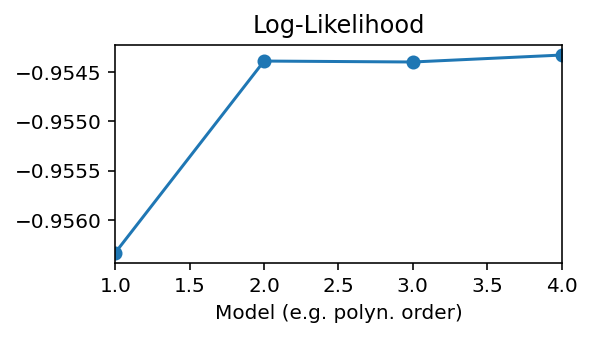

In [10]:
poly_orders = range(1, 5)
mll = []
for K in tqdm(poly_orders):
    bigX_train = build_X(X_train[:10000], K)
    w_posterior_mu, w_posterior_Sigma = compute_posterior(bigX_train, y_train[:10000], sigma2priorweights, sigma2noise)
    y_posterior_mu, _ = compute_predictive(X_test[:10000], w_posterior_mu, w_posterior_Sigma, sigma2noise, K)
    mll_ = gaussian_loglik(y_test[:10000], y_posterior_mu, sigma2noise) #fetching the log-likelihood
    mll.append(np.mean(mll_))

fig, ax = plt.subplots(figsize=[4,2])
ax.plot(poly_orders, mll, '-oC0')
ax.margins(0, 0.05)
ax.set_title('Log-Likelihood');
ax.set_xlabel('Model (e.g. polyn. order)')
plt.show()

In [11]:
#the best model seems to be for a polynomial feature of 2 (if we want to stay simple)
K=2
bigX_train = build_X(X_train[:10000], K)
w_posterior_mu, w_posterior_Sigma = compute_posterior(bigX_train, y_train[:10000], sigma2priorweights, sigma2noise)
y_posterior_mu,  y_posterior_sigma2 = compute_predictive(X_test[:10000], w_posterior_mu, w_posterior_Sigma, sigma2noise, K)

Let's have a look at the posterior variance of the weights:

In [12]:
print("Number of input features: "+str(len(X_train[0]))+", Polynomial degree: "+str(K)+", Number of polynomial input features: "+str(len(bigX_train[0])))
print("Shape of the posterior covariance matrix of the weights: "+str(w_posterior_Sigma.shape))
print("Sum of the posterior covariance matrix of the weights: "+str(np.sum(w_posterior_Sigma)))

Number of input features: 200, Polynomial degree: 2, Number of polynomial input features: 600
Shape of the posterior covariance matrix of the weights: (600, 600)
Sum of the posterior covariance matrix of the weights: 1.4328404527129561


#####  The posterior variance of the weights is equal to  1.4328404527129561



Now, let's have a short glance at our predictions versus the real y_test values (not asked in the exercice):

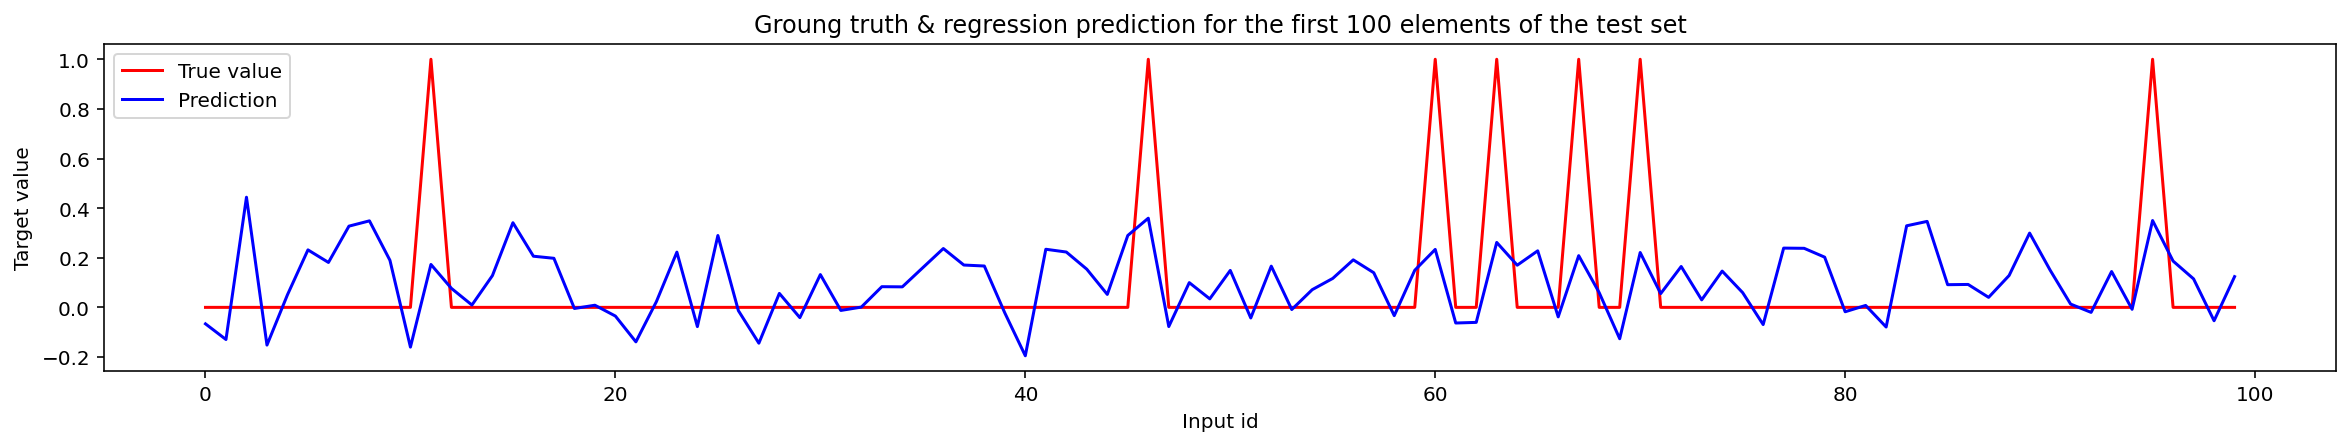

In [13]:
plt.figure(figsize=(20,3))
plt.title("Groung truth & regression prediction for the first 100 elements of the test set")
plt.plot(y_test[:100],'r', label = 'True value')
plt.plot(y_posterior_mu[:100], 'b', label =  "Prediction")
plt.xlabel("Input id")
plt.ylabel("Target value")
plt.legend()

As we can see, our predictions are very noisy, and too close to 0 when the prediction should be closer to 1.
This has to do with the simplified noise on the prior, the input features (maybe something else than polynomial would have been better), the fact that we could only train on 1/10 of the training set because of memory issues...

#### d) (text) Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy [5]

We could have a better look at the efficiency of our regression (in comparison with just tracing plots like above).

First, to discretize our predictions, we could use the following algorithm (pseudo code):
        
    For each float prediction p of the test data, do:
         if p >= 0.5, then set p to 1
         else set  p to 0

To display the confusion matrix, we can use the following algorithm (pseudo code):

    Initialize the confusion matrix: [true_negatives = 0,true_positives = 0,false_negatives = 0,false_positives = 0]
    For each discretized prediction ŷ of the X_test data (ŷ = 0 or ŷ = 1), do:
         if ŷ = 0 and y = 0 (with y the true label in y_test), increment true_negatives
         if ŷ = 1 and y = 1 (with y the true label in y_test), increment true_positives
         if ŷ = 1 and y = 0 (with y the true label in y_test), increment false_positives
         if ŷ = 0 and y = 1 (with y the true label in y_test), increment false_negatives  
            
To report the accuracy, the easiest way would be use the confusion matrix to compute:
     
    accuracy = (true_positives + true_negatives)/(size of the test set)
     
However, we might end up with a high accuracy, even with an unefficient model that only outputs 0, because of the sparsity of the positive targets.
One way to counter balance that could be to add hyperparameters in the accuracy computation, for example:
         
    modified_test_set_size = a*true_positives + b*true_negatives + false_positives + false_negatives
    accuracy = (a*true_positives + b*true_negatives)/(modified_test_set_size)
with a set to a high value and b to a low value, so that the high value of true_negatives does not influence too much the accuracy. 

Let's apply the most basic algorithm and get the confusion matrix and error rate:

In [14]:
confusion_matrix_linear = {'true_1':0,'true_0':0, 'false_0':0, 'false_1':0}
print("Min and max predictions: "+str(min(y_posterior_mu))+", "+str(max(y_posterior_mu)))
for i in tqdm(range(len(y_posterior_mu))):
    p = y_posterior_mu[i]
    y = y_test[i]
    if p <0.5: #the prediction is 0
        if y == 0 :
            confusion_matrix_linear['true_0'] +=1
        else:
            confusion_matrix_linear['false_0'] +=1
    else: #prediction is 1
        if y== 0:
            confusion_matrix_linear['false_1'] +=1
        else:
            confusion_matrix_linear['true_1'] +=1
            
accuracy_linear =   (confusion_matrix_linear['true_0'] + confusion_matrix_linear['true_1'])/len(y_posterior_mu) 
print("\n Confusion matrix: ")
print(confusion_matrix_linear) 
print("\n Accuracy: "+str(accuracy_linear)+", Error rate: "+str(1-accuracy_linear))

100%|██████████| 10000/10000 [00:00<00:00, 883904.58it/s]

Min and max predictions: -0.3393514977728348, 0.9272723092153896

 Confusion matrix: 
{'true_1': 84, 'true_0': 9020, 'false_0': 888, 'false_1': 8}

 Accuracy: 0.9104, Error rate: 0.08960000000000001


As expected, we have a lot of false 0, because of the sparsity of target 1 in the training set.

## 2. Logistic Regression

### 1) Metropolis-Hastings algorithm related questions

#### a) (code) The goal is to implement a Bayesian logistic regression classifier; assume a Gaussian prior on the parameters. As a first step, implement a Markov chain Monte Carlo inference algorithm to infer parameters (you should already have an implementation of the Metropolis-Hastings algorithm from the lab sessions). [10]

In [15]:
#Helper functions
jitter = 1e-10 #To avoid NAN in the logs

def logistic(z):
    return 1/(1 + np.exp(-z))

class BernoulliLikelihood():
    def logdensity(self, y, p):
        return y * np.log(p +jitter) + (1-y) * np.log(1-p + jitter)

class NormalPrior():
    def __init__(self, sigma2x):
        self.sigma2x = sigma2x
        
    def logdensity(self, x):
        return scipy.stats.multivariate_normal.logpdf(x, cov=self.sigma2x)

In [16]:
class MHSampler():
    @property
    def samples(self):
        return self._samples
    @samples.getter    
    def samples(self):
        return np.asarray(self._samples)
    
    def __init__(self, initial_sample, likelihood, prior):
        self.likelihood = likelihood
        self.prior = prior
        self._samples = [initial_sample]
        
        
    def unnormalized_logposterior(self, w, X, y):
        p = logistic(np.dot(X,w)) 
        log_likelihood = np.sum(self.likelihood.logdensity(y, p))
        log_prior = self.prior.logdensity(w)
        return (log_likelihood + log_prior)
    

    def step(self, X, y, step_proposal):
        w_prev = self._samples[-1]
        w_proposal = w_prev + step_proposal * scipy.stats.multivariate_normal.rvs(cov=np.eye(len(w_prev)))
        
        log_gw_prev = self.unnormalized_logposterior(w_prev, X, y)
        log_gw_proposal = self.unnormalized_logposterior(w_proposal, X, y)
        
        acceptance_ratio = log_gw_proposal - log_gw_prev
        
       # print(acceptance_ratio,np.exp(acceptance_ratio))
        if acceptance_ratio >= 0:
            self._samples.append(w_proposal)
        else:
            u = np.random.random()
            if u < np.exp(acceptance_ratio):
                self._samples.append(w_proposal)
            else:
                self._samples.append(w_prev)
        
        return min(acceptance_ratio, 1)

In [17]:
set_seed()

likelihood = BernoulliLikelihood()
prior = NormalPrior(np.eye(X.shape[1]))

starting_point = np.zeros(X.shape[1])
sampler = MHSampler(starting_point, likelihood, prior)
set_seed()
for i in tqdm(range(1000)):
    sampler.step(X_train, y_train, 0.05)

100%|██████████| 1000/1000 [01:00<00:00, 16.41it/s]


(1001, 200)


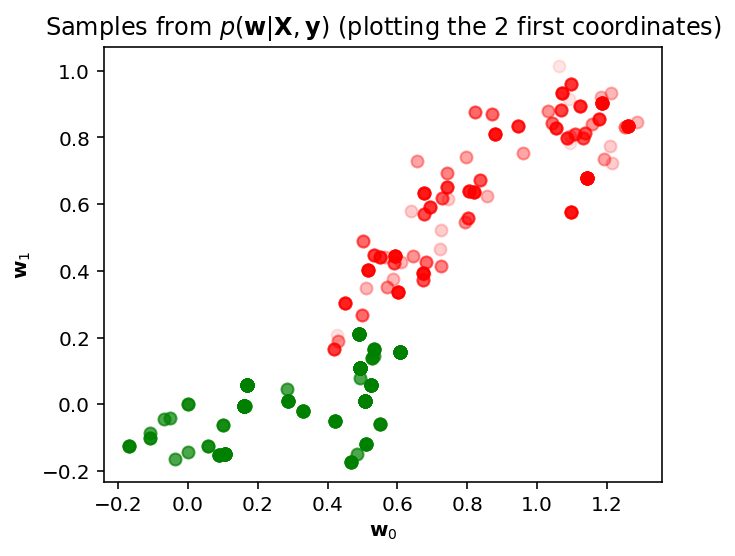

In [18]:
print(sampler.samples.shape)
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(sampler.samples[200:, 0], sampler.samples[200:, 1], "ro", alpha=0.1)
ax.plot(sampler.samples[:200, 0], sampler.samples[:200, 1], "go", alpha=0.7)
ax.set_xlabel(r'$\mathbf{w}_0$')
ax.set_ylabel(r'$\mathbf{w}_1$')
ax.set_title('Samples from $p(\mathbf{w}|\mathbf{X},\mathbf{y}) $ (plotting the 2 first coordinates)')
plt.show()

#### c)  (code) Based on samples from the posterior over model parameters, write a function that computes the predictive distribution, and write the necessary functions to evaluate classification metrics such as the log-likelihood on test data and error rate ( Metropolis-Hastings part). 

Our prediction will be the average prediction with the last 100 sampled weights (closer to the ideal weights than the previous ones)

In [19]:
def predict(x_new, w_samples):
    return logistic(np.dot(x_new, w_samples.T)).mean(axis=1)

y_predict = predict(X_test, sampler.samples[len(sampler.samples)-100:])
print(y_predict.shape, y_test.shape)

(100000,) (100000,)


In [20]:
confusion_matrix_metropolis = {'true_1':0,'true_0':0, 'false_0':0, 'false_1':0}
print("Min and max predictions: "+str(min(y_predict))+", "+str(max(y_predict)))
for i in tqdm(range(len(y_predict))):
    p = y_predict[i]
    y = y_test[i]
    if p <0.5: #the prediction is 0
        if y == 0 :
            confusion_matrix_metropolis['true_0'] +=1
        else:
            confusion_matrix_metropolis['false_0'] +=1
    else: #prediction is 1
        if y== 0:
            confusion_matrix_metropolis['false_1'] +=1
        else:
            confusion_matrix_metropolis['true_1'] +=1
            
accuracy_metropolis =   (confusion_matrix_metropolis['true_0'] + confusion_matrix_metropolis['true_1'])/len(y_predict) 
print("\n Confusion matrix: ")
print(confusion_matrix_metropolis) 
print("\n Accuracy: "+str(accuracy_metropolis)+", Error rate: "+str(1-accuracy_metropolis))
log_likelihood_metropolis = np.sum(sampler.likelihood.logdensity(y_test, y_predict))
print("\n Log-likelihood on test data: "+str(log_likelihood_metropolis))

100%|██████████| 100000/100000 [00:00<00:00, 890517.97it/s]

Min and max predictions: 0.0013108325441955667, 0.9201788780739995

 Confusion matrix: 
{'true_1': 562, 'true_0': 89576, 'false_0': 9515, 'false_1': 347}

 Accuracy: 0.90138, Error rate: 0.09862000000000004

 Log-likelihood on test data: -28187.233350775357


Let's have a look at what the predictions look like:

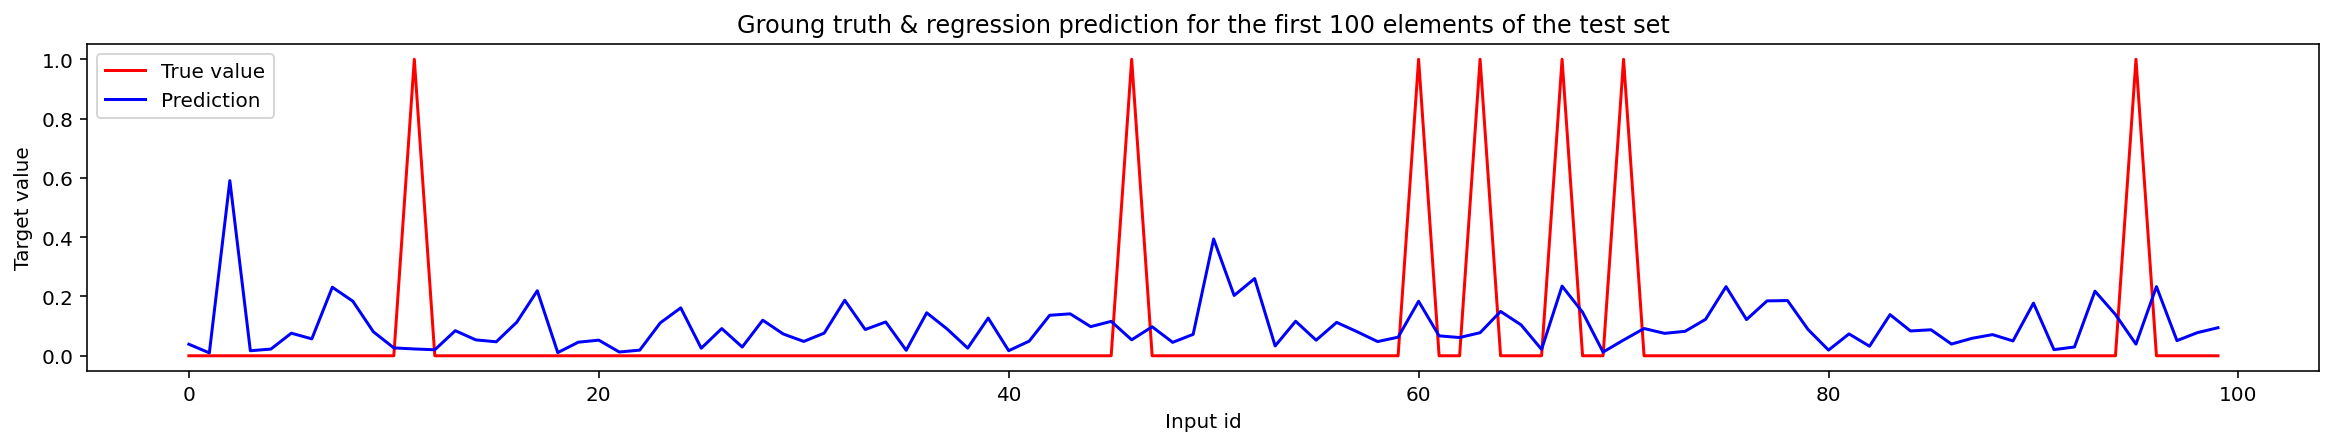

In [21]:

plt.figure(figsize=(20,3))
plt.title("Groung truth & regression prediction for the first 100 elements of the test set")
plt.plot(y_test[:100],'r', label = 'True value')
plt.plot(y_predict[:100], 'b', label =  "Prediction")
plt.xlabel("Input id")
plt.ylabel("Target value")
plt.legend()

Same as for the bayesian linear case, our model is too often "biased" towards 0 when the true value is 1...

#### d) (text) Comment on the tuning of the Metropolis-Hastings algorithm, and how to guarantee that samples are representative of samples of the posterior over model parameters. [5]

The tuning of this algorithm is quite complex. It takes into account:
- the number of sampled weights we use to make our predictions
- the step proposal (to sample a new weight matrix). Indeed, a smaller step proposal seems (from the tests I did) to allow more often a new weight to be added, whereas a too great one seems to reduce the chances of acceptation of a new sampled weight, and to keep a longer time the same weight. This has to do with the likelihood becoming too small. 

Indeed, the step proposal influences the output error rate. It should be low enough, if we want to converge and not diverge, but high enough, if we want to converge rapidely enough. Below are some error rates with several step proposals, when we make predictions with the 100 last sampled weights :

--> 0.10206000000000004 for step proposal = 0.1

--> 0.10077000000000003 step proposal = 0.01

--> 0.09862000000000004 step proposal = 0.05

### 2) Variational inference related questions

#### b) (code) Implement the variational approximation we studied in the course to obtain an approximation to the posterior over model parameters (you should already have an implementation of the from the lab sessions). [10]

We will this time use variational inference. For simplicity, we will assume that the posterior and prior distributions have a diagonal covariance matrix

In [22]:
#Distribution functions
jitter = 1e-10

class Distribution(nn.Module):  
    pass
        
class Bernoulli(Distribution):
    @args_as_tensors(1, 2)
    def logdensity(self, y, p):
        return  y * torch.log(p + jitter) + (1-y) * torch.log(1-p + jitter) 
    
class NormalDiagonal(Distribution):
    @property
    def var(self):
        return self.logvar.exp()
    
    def extra_repr(self):
        return 'train=%s' % self.train
    
    def __init__(self, d, train=True):
        super(NormalDiagonal, self).__init__()
        self.train = train
        self.d = d
        self.mean = nn.Parameter(torch.zeros(d), requires_grad=train)
        self.logvar = nn.Parameter(torch.zeros(d), requires_grad=train)
    
    def sample(self, n=1):
        #print("SAMPLE")
        eps = torch.rand((n, self.d[0], self.d[1]))-0.5
        samples = self.mean  + eps*self.var.sqrt()
        return samples


The variational inference lab was more relying on PyTorch... Therefore, I will redefine my helper functions in PyTorch for this part. This relies heavily on the provided code during the lab sessions.

In [23]:


_KL_REGISTRY = {}  # Source of truth mapping a few general (type, type) pairs to functions.
_KL_MEMOIZE = {}  # Memoized version mapping many specific (type, type) pairs to functions.

@total_ordering
class _Match(object):
    __slots__ = ['types']

    def __init__(self, *types):
        self.types = types

    def __eq__(self, other):
        return self.types == other.types

    def __le__(self, other):
        for x, y in zip(self.types, other.types):
            if not issubclass(x, y):
                return False
            if x is not y:
                break
        return True

def _dispatch_kl(type_q, type_p):
    matches = [(super_q, super_p) for super_q, super_p in _KL_REGISTRY
               if issubclass(type_q, super_q) and issubclass(type_p, super_p)]
    if not matches:
        return NotImplemented
    left_q, left_p = min(_Match(*m) for m in matches).types
    right_p, right_q = min(_Match(*reversed(m)) for m in matches).types
    left_fun = _KL_REGISTRY[left_q, left_p]
    right_fun = _KL_REGISTRY[right_q, right_p]
    if left_fun is not right_fun:
        logger.warning('Ambiguous kl_divergence({}, {}). Please register_kl({}, {})'.format(
            type_q.__name__, type_p.__name__, left_q.__name__, right_p.__name__))
    return left_fun


def register_kl(type_q, type_p):
    """
    Decorator to register a pairwise function with kl_divergence.
    Usage:

        @register_kl(Normal, Normal)
        def kl_normal_normal(q, p):
            # insert implementation here
    """
    if not isinstance(type_q, type) and issubclass(type_q, BaseDistribution):
        raise TypeError('Expected type_q to be a Distribution subclass but got {}'.format(type_q))
    if not isinstance(type_p, type) and issubclass(type_p, BaseDistribution):
        raise TypeError('Expected type_p to be a Distribution subclass but got {}'.format(type_p))
    
    def decorator(fun):
        _KL_REGISTRY[type_q, type_p] = fun
        _KL_MEMOIZE.clear()  # reset since lookup order may have changed
        print('KL divergence between \'%s\' and \'%s\' registered.' % (type_q.__name__, type_p.__name__))
        return fun
    return decorator


def kl_divergence(q, p):
    r"""Compute Kullback-Leibler divergence KL(p|q) between two distributions."""
    try:
        fun = _KL_MEMOIZE[type(q), type(p)]
    except KeyError:
        fun = _dispatch_kl(type(q), type(p))
        _KL_MEMOIZE[type(q), type(p)] = fun
    if fun is NotImplemented:
        raise NotImplementedError('KL divergence for pair %s - %s not registered' % (type(q).__name__,
                                                                                     type(p).__name__))
    return fun(q, p)

In [24]:
@register_kl(NormalDiagonal, NormalDiagonal)
def _normaldiagonal_normaldiagonal(q, p):
    kl = 0.5*torch.sum(torch.log(p.var/q.var) + (q.var + (q.mean -p.mean)**2)/p.var - 1)
    return kl

KL divergence between 'NormalDiagonal' and 'NormalDiagonal' registered.


In [25]:
def logistic(z):
    return  1/(1 + torch.exp(-z)) 

class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()

        self.prior_w = NormalDiagonal(input_dim, False)
        self.posterior_w = NormalDiagonal(input_dim)
        
    @args_as_tensors(1)
    def predict_y(self, X, mc_samples=1 ):
        w_samples = self.posterior_w.sample(mc_samples)
        y_samples = logistic(torch.matmul(X, w_samples))
        return y_samples
        

In [26]:
class VariationalObjective(nn.Module):    
    def __init__(self, model, likelihood, N, mc_samples=1):
        super(VariationalObjective, self).__init__()
        self.N = N
        self.model = model
        self.likelihood = likelihood
        self.mc_samples = mc_samples
        
    def expected_loglikelihood(self, Xbatch, ybatch):
        ypred = self.model.predict_y( Xbatch, self.mc_samples)
        scale = self.N/(len(Xbatch)*self.mc_samples)
        logliks = scale * torch.sum(self.likelihood.logdensity(ybatch.reshape((len(ybatch),1)), ypred))
        return logliks

    def kl(self):
        return kl_divergence(self.model.posterior_w,self.model.prior_w)
    
    def compute_objective(self, Xbatch, ybatch):
        return - self.expected_loglikelihood(Xbatch, ybatch) + self.kl()

In [27]:
class Dataset():
    def __init__(self, X, y, minibatch_size):
        self.X = X
        self.y = y 
        self.minibatch_size = min(minibatch_size, len(self.X))
        self._i = 0  
    def next_batch(self):  
        if len(self.X) <= self._i + self.minibatch_size:
            shuffle = np.random.permutation(len(self.X))
            self.X = self.X[shuffle]
            self.y = self.y[shuffle]
            Xbatch = self.X[self._i:]
            ybatch = self.y[self._i:]
            self._i = 0
            return Xbatch, ybatch

        Xbatch = self.X[self._i:self._i + self.minibatch_size]
        ybatch = self.y[self._i:self._i + self.minibatch_size]
        self._i += self.minibatch_size
        return Xbatch, ybatch
    

In [28]:
class Summary:
    @property
    def data(self):
        data = pd.DataFrame(self._data, columns=['step', self.name, 'time'])
        data.time = data.time - data.time.iloc[0]
        return data
    
    def __init__(self, name):
        """A simple class to store some values during optimization"""
        self.name = str(name)
        self._data = []
    
    def append(self, step, value):
        self._data.append([step, float(value.detach().numpy()), time.time()])

Let's have a look at the influence of the mc_samples parameter:

100%|██████████| 1000/1000 [00:03<00:00, 332.31it/s]


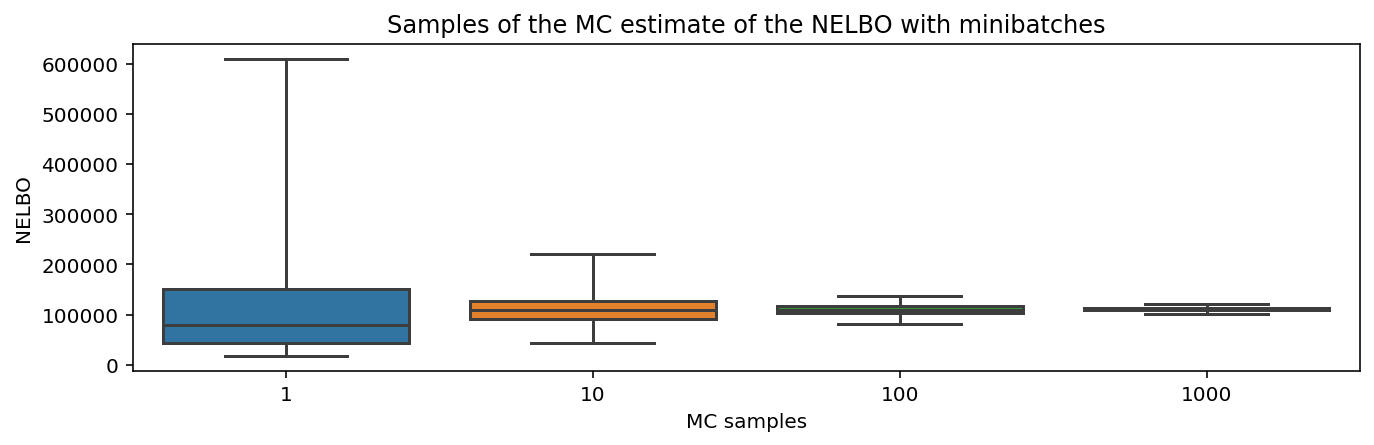

In [29]:
set_seed()

likelihood =  Bernoulli()
model = LogisticRegression([X_train.shape[1],1])
nelbo = VariationalObjective( model, likelihood, N = len(X_train), mc_samples=500)
dataset = Dataset(X_train, y_train, minibatch_size=10000)

nelbo_samples = {}
num_of_nelbo_samples = 1000

dataset = Dataset(X_train, y_train, minibatch_size=100)

with torch.no_grad():
    
    nelbo.mc_samples = 1
    nelbo_samples['1'] = []
    for i in tqdm(range(num_of_nelbo_samples)):
        Xbatch, ybatch = dataset.next_batch()
        nelbo_samples['1'] = nelbo_samples['1'] + [nelbo.compute_objective( Xbatch, ybatch ) ]
    
    nelbo.mc_samples = 10
    nelbo_samples['10'] = []
    for i in tqdm(range(num_of_nelbo_samples)):
        Xbatch, ybatch = dataset.next_batch()
        nelbo_samples['10'] = nelbo_samples['10'] + [nelbo.compute_objective( Xbatch, ybatch ) ]
    
    nelbo.mc_samples = 100
    nelbo_samples['100'] = []
    for i in tqdm(range(num_of_nelbo_samples)):
        Xbatch, ybatch = dataset.next_batch()
        nelbo_samples['100'] = nelbo_samples['100'] + [nelbo.compute_objective( Xbatch, ybatch ) ]

    nelbo.mc_samples = 1000
    nelbo_samples['1000'] = []
    for i in tqdm(range(num_of_nelbo_samples)):
        Xbatch, ybatch = dataset.next_batch()
        nelbo_samples['1000'] = nelbo_samples['1000'] + [nelbo.compute_objective( Xbatch, ybatch ) ]



fig, ax = plt.subplots(figsize=[11, 3])
sns.boxplot(data=pd.DataFrame(nelbo_samples), ax=ax,  whis=np.inf )
ax.set_title('Samples of the MC estimate of the NELBO with minibatches')
ax.set_xlabel('MC samples')
ax.set_ylabel('NELBO')
ax.margins(0,0.05)
plt.show()

Indeed, there is less  variance in the MC estimate of the NELBO when we get a lot of mc samples. It becomes more reliable for estimation.

Now, let's fit our model to the training data:

In [30]:
#Initializing 
likelihood =  Bernoulli()
model = LogisticRegression([X_train.shape[1],1])
nelbo = VariationalObjective( model, likelihood, N = len(X_train), mc_samples=500)
dataset = Dataset(X_train, y_train, minibatch_size=10000)

100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


Training complete 
 Final loss: 65276.95703125


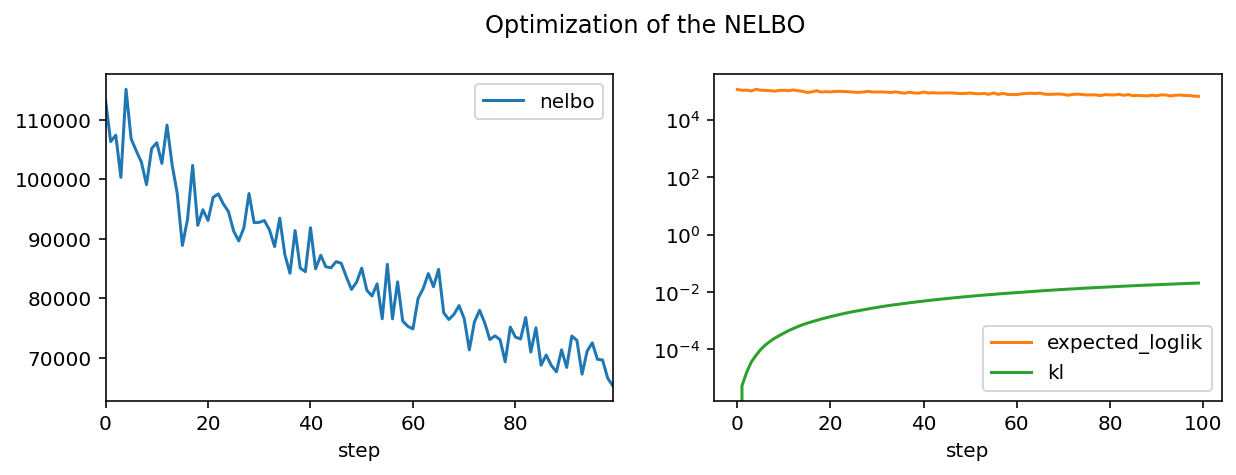

In [31]:
nelbo_summary = Summary('nelbo')
nll_summary = Summary('expected_loglik')
kl_summary = Summary('kl')

optim = torch.optim.SGD(model.parameters(), lr= 1e-8)
num_iterations = 100

for step in tqdm(range(num_iterations)):
    optim.zero_grad()
    
    Xbatch, ybatch = dataset.next_batch() 
    loss = nelbo.compute_objective( Xbatch, ybatch) 
    
    nelbo_summary.append(step, loss)
    nll_summary.append(step, loss - nelbo.kl())
    kl_summary.append(step, nelbo.kl())
 
    loss.backward()
    optim.step()

print("Training complete \n Final loss: "+str(loss.data.item()))

#let's have a look at how went the training process:
fig, axs = plt.subplots(1, 2, figsize=[10, 3])

nelbo_summary.data.plot(x='step', y='nelbo', ax=axs[0]);
nll_summary.data.plot(x='step', y='expected_loglik', ax=axs[1], c='C1');
kl_summary.data.plot(x='step', y='kl', ax=axs[1], c='C2');
axs[1].semilogy();
fig.suptitle('Optimization of the NELBO', y=1.02)
axs[0].margins(0, 0.05)

#### c) (code) Based on samples from the posterior over model parameters, write a function that computes the predictive distribution, and write the necessary functions to evaluate classification metrics such as the log-likelihood on test data and error rate. (Variational Inference part)

The function to compute the predictive distribution is already partially written in the ***LogisticRegression*** class (predict_y).
To get the predictions, we just have to take the mean. And for the error rate, we will proceed like for the previous models.

In [32]:
with torch.no_grad():
    x_new = torch.tensor(X_test).float()
    y_new = model.predict_y(x_new, mc_samples=500).mean(dim=0) #the prediction
    
confusion_matrix_vi = {'true_1':0,'true_0':0, 'false_0':0, 'false_1':0}
for i in tqdm(range(len(y_new))):
    p = y_new[i]
    y = y_test[i]
    if p <0.5: #the prediction is 0
        if y == 0 :
            confusion_matrix_vi['true_0'] +=1
        else:
            confusion_matrix_vi['false_0'] +=1
    else: #prediction is 1
        if y== 0:
            confusion_matrix_vi['false_1'] +=1
        else:
            confusion_matrix_vi['true_1'] +=1
            
accuracy_vi =   (confusion_matrix_vi['true_0'] + confusion_matrix_vi['true_1'])/len(y_new) 
print("\n Confusion matrix: ")
print(confusion_matrix_vi) 
print("\n Accuracy: "+str(accuracy_vi)+", Error rate: "+str(1-accuracy_vi))
log_likelihood_vi =torch.sum(likelihood.logdensity(y_test.reshape(len(y_test),1), y_new)).data.item()
print("\n Log-likelihood on test data: "+str(log_likelihood_vi))



100%|██████████| 100000/100000 [00:01<00:00, 68500.71it/s]


 Confusion matrix: 
{'true_1': 0, 'true_0': 89923, 'false_0': 10077, 'false_1': 0}

 Accuracy: 0.89923, Error rate: 0.10077000000000003

 Log-likelihood on test data: -43256.3828125


This is not very good ... The model just learned to predict 0 every time. We can have a look at this issue with this plot, for the 100 first elements of the test set:

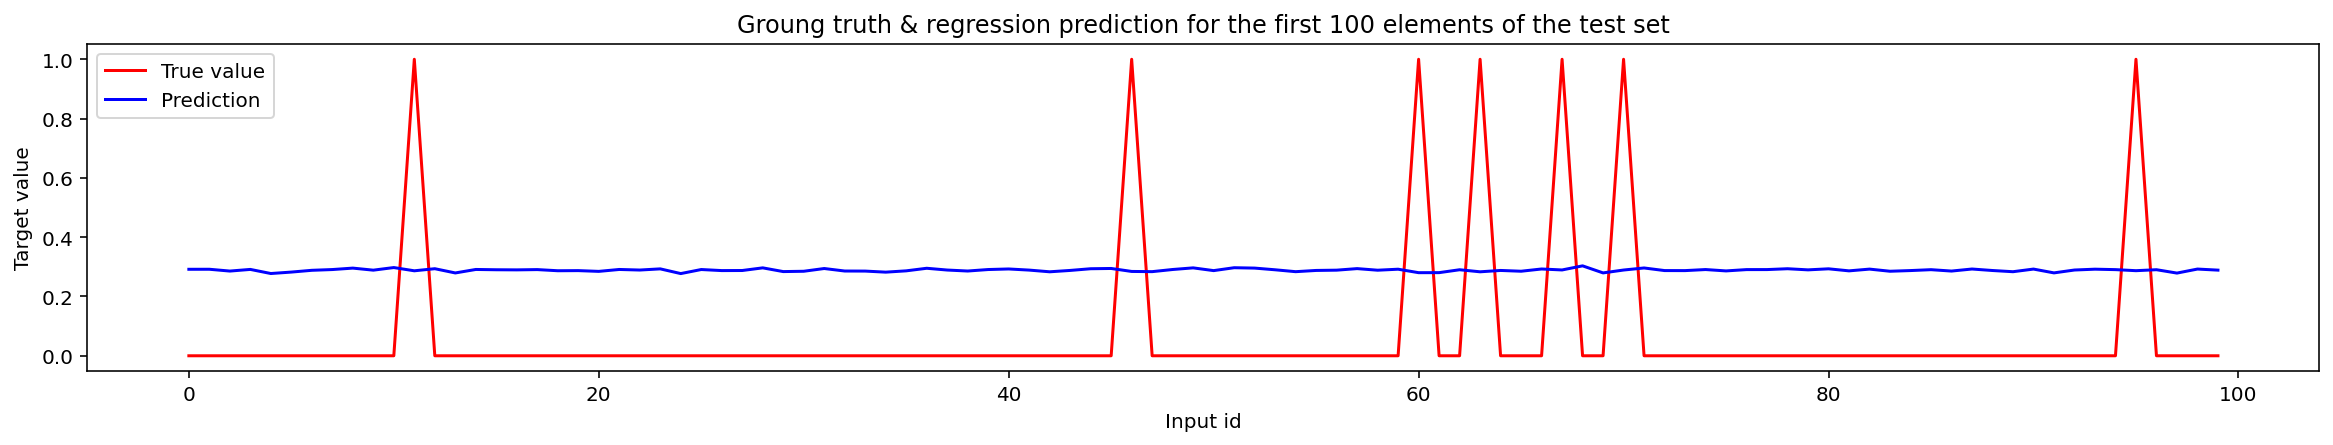

In [33]:
plt.figure(figsize=(20,3))
plt.title("Groung truth & regression prediction for the first 100 elements of the test set")
plt.plot(y_test[:100],'r', label = 'True value')
plt.plot(y_new[:100], 'b', label =  "Prediction")
plt.xlabel("Input id")
plt.ylabel("Target value")
plt.legend()

#### e) (text) Comment on the tuning of the variational inference algorithm, and discuss the behavior of the optimization with respect to the choice of the optimizer/step-size. [5]

Once again, the learning rate has to be well chosen. We can see that we manage to, as wanted, diminish the NELBO, at the expense of the KL that increases and the log likelihood that decreases a bit.
To do so, the learning rate has to be small enough to avoid divergence, and high enough to have a reasonable training time. 
Also, other optimizers could surely be better: we can think about ADAM optimizer, for example...

#### f) (text) Report the error metrics implemented in (b) and the confusion matrix on the test data. Discuss logistic regression performance with respect to the performance of Bayesian linear regression. [5]

The error metrics such as the NELBO can be seen at the end of the training process in question **b)**, and others such as the confusion matrix can be seen in question **c)** (variational inference part).

Because of the memory issue, I could not implement the bayesian linear regression to the whole dataset, which makes it more difficult to compare. But it seems that the polynomial feature preprocessing helps (it could also be implemented for the logistic regressions). 
In fact, with enough training time and good hyperparameter tuning, we would expect the logistic model to outperform the linear model, as it adds some nonlinearity, which is often helpful with finding patterns in the dataset. However, this depends mostly of the nature of the dataset.

In [34]:
print('--- Confusion matrices & accuracies --- ')
print('Linear model: '+str(confusion_matrix_linear)+" accuracy: "+str(accuracy_linear))
print('Metropolis-Hastings model: '+str(confusion_matrix_metropolis)+" accuracy: "+str(accuracy_metropolis))
print('Variational inference model: '+str(confusion_matrix_vi)+" accuracy: "+str(accuracy_vi))

--- Confusion matrices & accuracies --- 
Linear model: {'true_1': 84, 'true_0': 9020, 'false_0': 888, 'false_1': 8} accuracy: 0.9104
Metropolis-Hastings model: {'true_1': 562, 'true_0': 89576, 'false_0': 9515, 'false_1': 347} accuracy: 0.90138
Variational inference model: {'true_1': 0, 'true_0': 89923, 'false_0': 10077, 'false_1': 0} accuracy: 0.89923


### 3) Metropolis-Hastings algorithm vs Variational inference 

#### g) (text) Compare the uncertainties on predictions obtained by the Metropolis-Hastings algorithm and variational inference. First, compare the log-likelihood on test data as a global metric to assess which inference method yields better uncertainty quantification.Second, pick a few test points for which the mean of the predictive distribution is (a) around 0.5 (b) giving a correct prediction (c) giving a wrong prediction, and visualize/discuss what the predictive distribution looks like. Discuss the difference between the Metropolis-Hastings algorithm and variational inference. [15]

In [36]:
print("Log likelihoods: ")
print("Metropolis-Hastings: "+str(log_likelihood_metropolis)+", Variationnal Inference: "+str(log_likelihood_vi))

Log likelihoods: 
Metropolis-Hastings: -28187.233350775357, Variationnal Inference: -43256.3828125


The Metropolis-Hastings method seems more adapted. Indeed, the log likelihood is higher, and from the confusion matrices, we can see that Metropolis-Hasting does not just predict 0 to every input, where variational inference unfortunately does. Therefore, Metropolis-Hastings method yields better uncertainty quantification.

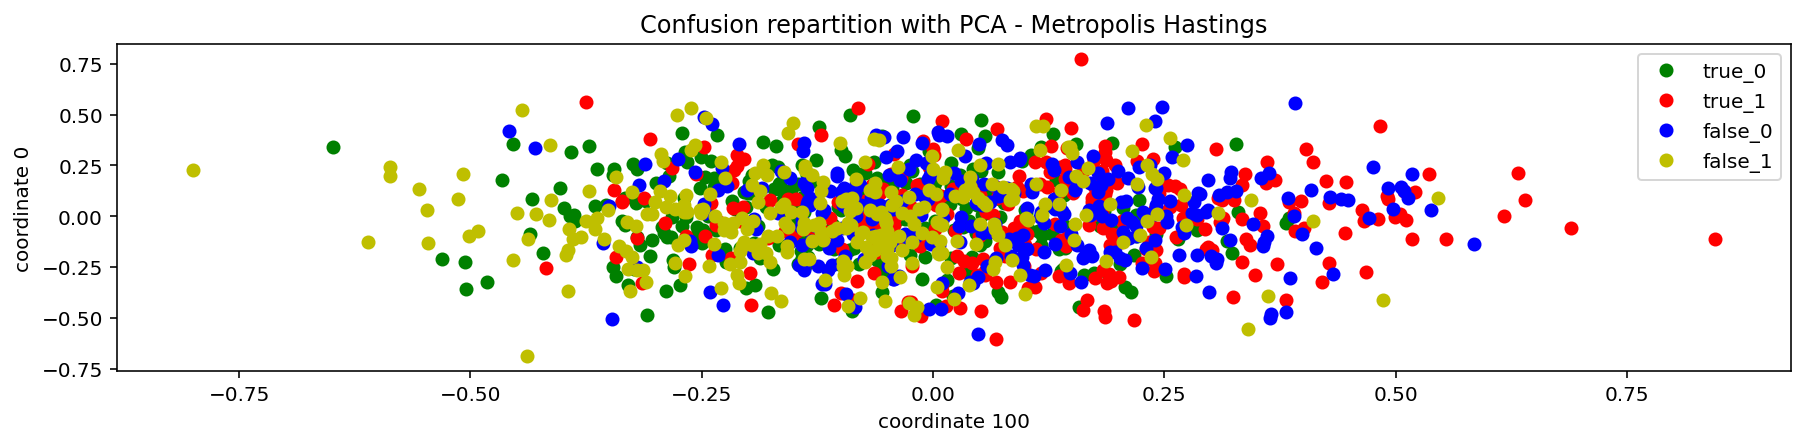

In [89]:
#Taking some points, such as the "mean" of the predictive distribution should be near 0.5, for metropolis:
confusion_ids = {'true_1':[],'true_0':[], 'false_0':[], 'false_1':[]}
num_points = 300
for i in range(len(X_test)):
    fp,fn,tp,tn=len(confusion_ids['false_1']),len(confusion_ids['false_0']),len(confusion_ids['true_1']),len(confusion_ids['true_0'])
    if fp == num_points and fn  == num_points and tp == num_points and tn == num_points:
        break
    elif y_test[i]==0: #label = 0
        if y_predict[i] <0.5 and tn <num_points: #prediction = label = 0
            confusion_ids['true_0'].append(i)
        elif fp <num_points:
            confusion_ids['false_1'].append(i)
    else : #label = 1
        if y_predict[i] <0.5 and fn <num_points:
            confusion_ids['false_0'].append(i)
        elif tp <num_points:
            confusion_ids['true_1'].append(i)
            
#Let's use PCA for better representation:
pca = PCA(n_components=2)
sampled_ids=  confusion_ids['true_0'] + confusion_ids['true_1'] + confusion_ids['false_0'] +  confusion_ids['false_1']
pca.fit(X_test[sampled_ids], y_test[sampled_ids])
reduced_X_test = pca.transform(X_test)

plt.figure(figsize=(15,3))
plt.title("Confusion repartition with PCA - Metropolis Hastings")
plt.plot(reduced_X_test[confusion_ids['true_0']][:,0],reduced_X_test[confusion_ids['true_0']][:,1] ,'go', label='true_0',alpha = 1)
plt.plot(reduced_X_test[confusion_ids['true_1']][:,0], reduced_X_test[confusion_ids['true_1']][:,1],'ro', label = 'true_1',alpha = 1)
plt.plot(reduced_X_test[confusion_ids['false_0']][:,0],reduced_X_test[confusion_ids['false_0']][:,1] ,'bo', label='false_0',alpha = 1)
plt.plot(reduced_X_test[confusion_ids['false_1']][:,0], reduced_X_test[confusion_ids['false_1']][:,1],'yo', label = 'false_1', alpha = 1)
plt.xlabel("coordinate 100")
plt.ylabel("coordinate 0")
plt.legend()



Even with PCA to help us see patterns in the data, it is very difficult to understand the patterns the model believes to be true...

# TODO: 
Discuss the difference between the Metropolis-Hastings algorithm and variational inference

### Annex

Below, you can have a look at some functions (from the bayesian linear regression lab)  that could allow us to do bayesian linear regression by being bayesian on the noise (with Gamma distribution)  :

    def compute_posterior(X, y, mu0, Sigma0, a0, b0):
        Sigma0_inverse = np.linalg.inv(Sigma0) #to change : for a better method (choleski), such as all inverses in this lab
        Sigma = np.linalg.inv(Sigma0_inverse + np.dot(X.T,X))  
        mu =   np.dot(Sigma,np.dot(Sigma0_inverse,mu0)+np.dot(X.T,y))
        a =    a0+len(X)/2 
        b = b0 + 0.5*(np.dot(np.dot(mu0.T,Sigma0),mu0) + np.dot(y.T,y)-np.dot(np.dot(mu.T,Sigma),mu))
        return mu, Sigma, a, b

    def compute_predictive_posterior(Xnew, mu, Sigma, a, b):
        Xnew = build_X(Xnew, len(mu)-1)
        m = np.dot(Xnew,mu)
        c = (b/a)*(np.eye(len(Xnew))+np.dot(np.dot(Xnew,Sigma),Xnew.T))
        dof = 2*a        
        return m, np.diag(c), dof

    def sample_from_student_t(m, v, dof, n):
        eps = np.random.standard_t(dof, n).reshape(-1, 1)
        sample = m+ eps*v
        return sample